<a href="https://colab.research.google.com/github/ppages01/big-data-challenge/blob/master/aws_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Java, Spark, and Findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

In [2]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar


--2020-06-28 17:49:17--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar’

postgresql-42.2.9.j 100%[===================>] 892.61K  4.76MB/s    in 0.2s    

2020-06-28 17:49:18 (4.76 MB/s) - ‘postgresql-42.2.9.jar’ saved [914037/914037]



In [3]:
import matplotlib.pyplot as plt

In [4]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

In [5]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Wireless_v1_00.tsv.gz"
spark.sparkContext.addFile(url)
df = spark.read.option('header', 'true').csv(SparkFiles.get("amazon_reviews_us_Wireless_v1_00.tsv.gz"), inferSchema=True, sep='\t')

# Show DataFrame
df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-------------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|        review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-------------------+
|         US|   16414143|R3W4P9UBGNGH1U|B00YL0EKWE|     852431543|LG G4 Case Hard T...|        Wireless|          2|            1|          3|   N|                Y|Looks good, funct...|2 issues  -  Once...|2015-08-31 00:00:00|
|         US|   50800750|R15V54KBMTQWAY|B00XK95RPQ|     516894650|Selfie Stick Fibl...| 

In [6]:
###########################################
#                                         #
#                                         #
#          CLEANUP & TRANSFORM            #
#                                         #
#                                         #
###########################################

In [7]:
from pyspark.sql.types import IntegerType
df = df.withColumn("star_rating", df["star_rating"].cast(IntegerType()))


In [8]:
from pyspark.sql import functions as f
df = df.withColumn('review_status', f.when(f.col('star_rating') > 3, "Positive").otherwise("Negative"))


In [9]:
df = df.dropna()
df.show(10, False)
                       

+-----------+-----------+--------------+----------+--------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+-----------+-------------+-----------+----+-----------------+-------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
#df = df.withColumn("fixed_date", year(df['review_date']))
from pyspark.sql.functions  import date_format

df = df.withColumn("review_date", date_format('review_date', "yyyy-MM-dd"))
df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+-------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|review_status|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+-------------+
|         US|   16414143|R3W4P9UBGNGH1U|B00YL0EKWE|     852431543|LG G4 Case Hard T...|        Wireless|          2|            1|          3|   N|                Y|Looks good, funct...|2 issues  -  Once...| 2015-08-31|     Negative|
|         US|   50800750|R15V54KBMTQWAY|B00XK95RPQ|     51689465

In [11]:
df.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- review_status: string (nullable = false)



In [12]:
###########################################
#                                         #
#                                         #
#        CREATE 4 DFs FOR DB LOADING      #
#                                         #
#                                         #
###########################################

In [13]:
# CREATE A TABLE OF COUNT OF CUSTOMER REVIEWS> THIS DATAFRAME WILL THEN LOAD INTO A TABLE
customercount = df.groupby("customer_id").agg({"customer_id":"count"}).withColumnRenamed("count(customer_id)","customer_count")
#customercount = customercount.dropna()
customercount = customercount.withColumn("customer_count", customercount["customer_count"].cast(IntegerType()))
customercount.show()


+-----------+--------------+
|customer_id|customer_count|
+-----------+--------------+
|   46909180|             6|
|   42560427|             7|
|   43789873|             3|
|   22037526|             2|
|   34220092|             2|
|   42801586|             1|
|    9565734|             2|
|   15829398|             1|
|   38247118|             1|
|   32478248|             2|
|   48114630|             1|
|   23085063|             1|
|   32787070|             3|
|   43515569|             1|
|    4919528|             2|
|    5088547|             2|
|   41852407|             3|
|   49703087|             1|
|   12713799|             1|
|   36728141|             8|
+-----------+--------------+
only showing top 20 rows



In [14]:
#CREATE TABLE OF PRODUCT ID & PRODUCT TITLE > THIS DATAFRAME WILL THEN LOAD INTO A TABLE
productcount = df.dropDuplicates(['product_id']) 

productcount = productcount[['product_id','product_title']]
productcount.show()

+----------+--------------------+
|product_id|       product_title|
+----------+--------------------+
|1060104342|Premium Asus MeMO...|
|159775045X|National Geograph...|
|5891090414|           STAND-N02|
|6175001532|Colorful Abstract...|
|9572548964|Pink Flower Purpl...|
|9713000463|Rapid Charger KIT...|
|9838427853|PowerBear® Samsun...|
|9861033181|Purple Flower Blu...|
|9983781239|PREMIUM USB Adapt...|
|9984225437|Sanyo MM-8300 Sta...|
|B00000J0IV|Magellan Leather ...|
|B00000J1PX|Cobra MAVOX Voice...|
|B00003OPEV|Garmin eMap Delux...|
|B0000520T4|Ericsson 650 mAh ...|
|B00005I9QK|Aquapac Waterproo...|
|B00005QT35|Garmin GPS 45 Per...|
|B00006JP9X|AMERICAN INTERNAT...|
|B00007EDL7|Sony DCC-E34CP Po...|
|B00008E1OH|Samsung Leather C...|
|B00008RCQS|Virgin Mobile Pay...|
+----------+--------------------+
only showing top 20 rows



In [33]:
#CREATE A TABLE OF review_id, customer_id,product_id,product_parent,review_date DATE this should be int eh format yyyy-mm-dd >THIS WILL LOAD INTO TABLE

from pyspark.sql.functions import to_date
reviews = df[["review_id","customer_id","product_id","product_parent","review_date"]]
reviews = reviews.withColumn("review_date", to_date(reviews["review_date"]))
reviews.show()

+--------------+-----------+----------+--------------+-----------+
|     review_id|customer_id|product_id|product_parent|review_date|
+--------------+-----------+----------+--------------+-----------+
|R3W4P9UBGNGH1U|   16414143|B00YL0EKWE|     852431543| 2015-08-31|
|R15V54KBMTQWAY|   50800750|B00XK95RPQ|     516894650| 2015-08-31|
| RY8I449HNXSVF|   15184378|B00SXRXUKO|     984297154| 2015-08-31|
|R18TLJYCKJFLSR|   10203548|B009V5X1CE|     279912704| 2015-08-31|
|R1NK26SWS53B8Q|     488280|B00D93OVF0|     662791300| 2015-08-31|
|R11LOHEDYJALTN|   13334021|B00XVGJMDQ|     421688488| 2015-08-31|
|R3ALQVQB2P9LA7|   27520697|B00KQW1X1C|     554285554| 2015-08-31|
|R3MWLXLNO21PDQ|   48086021|B00IP1MQNK|     488006702| 2015-08-31|
|R2L15IS24CX0LI|   12738196|B00HVORET8|     389677711| 2015-08-31|
|R1DJ8976WPWVZU|   15867807|B00HX3G6J6|     299654876| 2015-08-31|
|R3MRWNNR8CBTB7|    1972249|B00U4NATNQ|     577878727| 2015-08-31|
|R1DS6DKTUXAQK3|   10956619|B00SZEFDH8|     654620704| 2015-08

In [16]:
#CREATE A TABLE of review_id, star_rating, helpful_votes, total_votes, vine
vinereviews = df.filter(df.vine == "Y")
vinereviews = vinereviews[["review_id","star_rating","helpful_votes", "total_votes","review_body"]]
vinereviews = vinereviews.withColumnRenamed('review_body', "vine")
vinereviews.show()

+--------------+-----------+-------------+-----------+--------------------+
|     review_id|star_rating|helpful_votes|total_votes|                vine|
+--------------+-----------+-------------+-----------+--------------------+
|R344HMPGL4ZKPN|          4|            0|          0|The Defender Case...|
|R12DZ855BQWIV4|          4|            0|          1|I recently bought...|
|R1WPRIS0485ZHW|          5|            0|          0|I've been using t...|
|R2NLM7J0OW571M|          3|            0|          0|I would say the g...|
|R1MAOLI5FJHAFM|          4|          249|        261|Ever since the ve...|
|R3FLA3HN61KFUB|          5|            0|          0|Belkin makes grea...|
|R3DY1JNXDSMACX|          4|            2|          3|Looking at this d...|
| R9PYAUDIBJVEC|          4|           12|         22|I picked this pho...|
|R1QPR3PTNEUNVT|          5|            0|          0|This is stylish a...|
|R11EA9W01ASOYS|          5|            0|          1|I have trusted Ot...|
| RAUUNWUU5N

In [17]:
###########################################
#                                         #
#                                         #
#                LOADING                  #
#                                         #
#                                         #
###########################################

In [18]:
import getpass
pwd=getpass.getpass("Enter DB Access for PostgresSQL")






Enter DB Acces for PostgresSQL··········


In [19]:
# Configure settings for RDS
mode = "append"
jdbc_url="jdbc:postgresql://mypostgresdb.cdt05xwzykeb.us-east-2.rds.amazonaws.com:5432/my_data_class_db"
config = {"user":"root", 
          "password": pwd, 
          "driver":"org.postgresql.Driver"}


In [20]:
# type(customercount)

In [34]:
# customercount.printSchema()
# reviews.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- review_date: date (nullable = true)



In [22]:
customercount.write.jdbc(url=jdbc_url, table='customers', mode=mode, properties=config)


In [23]:
productcount.write.jdbc(url=jdbc_url, table='products', mode=mode, properties=config)

In [35]:
reviews.write.jdbc(url=jdbc_url, table='review_id_table', mode=mode, properties=config)

In [36]:
vinereviews.write.jdbc(url=jdbc_url, table='vine_table', mode=mode, properties=config)

In [ ]:
###########################################
#                                         #
#                                         #
#                ANALYSIS                 #
#                                         #
#                                         #
###########################################

In [ ]:
positive_reviews = df.groupby('review_status').agg({'review_status':'count'})
#.collect()[0][("count(review_status")]





In [ ]:
positive_reviews.show()

+-------------+--------------------+
|review_status|count(review_status)|
+-------------+--------------------+
|     Positive|             6326020|
|     Negative|             2676001|
+-------------+--------------------+



In [ ]:
df[['star_rating', 'helpful_votes', 'total_votes']].describe().show()

+-------+------------------+------------------+------------------+
|summary|       star_rating|     helpful_votes|       total_votes|
+-------+------------------+------------------+------------------+
|  count|           9001881|           9001881|           9001881|
|   mean|   3.8917818398177|0.8903038153914721|1.1573879947979762|
| stddev|1.4638208007143878|11.030083006409946|11.843696443744744|
|    min|                 1|                 0|                 0|
|    max|                 5|              5854|              6063|
+-------+------------------+------------------+------------------+



In [ ]:
df.columns

['marketplace',
 'customer_id',
 'review_id',
 'product_id',
 'product_parent',
 'product_title',
 'product_category',
 'star_rating',
 'helpful_votes',
 'total_votes',
 'vine',
 'verified_purchase',
 'review_headline',
 'review_body',
 'review_date',
 'review_status']

In [ ]:
df.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- review_status: string (nullable = false)



In [ ]:
# Average Rating grouped by verified purchase
df.groupby('verified_purchase').agg({'star_rating':'mean','verified_purchase':'count','helpful_votes':"mean"}).show()

+-----------------+------------------+------------------------+------------------+
|verified_purchase|  avg(star_rating)|count(verified_purchase)|avg(helpful_votes)|
+-----------------+------------------+------------------------+------------------+
|             null|              null|                       0|              null|
|                Y|3.8991187160595966|                 7929340|0.7031393533383611|
|                N| 3.837540010125487|                 1072541|2.2740184291323127|
+-----------------+------------------+------------------------+------------------+



In [ ]:
# Looking at vine vs nonvine reviews

In [ ]:
tot_vine = df[df['vine']=='Y']
tot_nonvine = df[df['vine'] =='N']
tot_vine.count()
tot_nonvine.count()
print(f"Total number of vine ratings for this category:{tot_vine.count()},  Non-Vine ratings with 4 or above: {tot_nonvine.count()}")

Total number of vine ratings for this category:17481,  Non-Vine ratings with 4 or above: 8984400


In [ ]:
# Show all of the occupations where salaries were above 80k
vine_ratings = df[(df['star_rating']> 4) & (df['vine'] == 'Y')]
nonvine_ratings = df[(df['star_rating']> 4) & (df['vine'] == 'N')]



#df.filter('star_rating>4').filter('df.vine'='Y').show()

In [ ]:
#rating of 4 or above
print(f"Count of Vine ratings with 4 or above:{vine_ratings.count()},  Non-Vine ratings with 4 or above: {nonvine_ratings.count()}")

Count of Vine ratings with 4 or above:6522,  Non-Vine ratings with 4 or above: 4818203


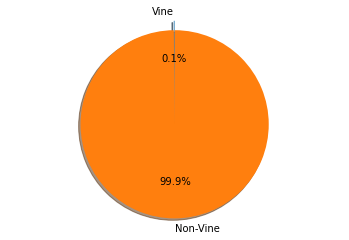

In [ ]:

labels = 'Vine', 'Non-Vine'
sizes = [vine_ratings.count(), nonvine_ratings.count()]
explode = (0, 0.1)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
###########################################
#                                         #
#                                         #
#          REVIEW TEXT ANALYSIS           #
#                                         #
#                                         #
###########################################

In [ ]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover

In [ ]:
tokenizer = Tokenizer(inputCol="review_body", outputCol="words")
wordsData = tokenizer.transform(df)
wordsData.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+-------------+--------------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|review_status|               words|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+-------------+--------------------+
|         US|   16414143|R3W4P9UBGNGH1U|B00YL0EKWE|     852431543|LG G4 Case Hard T...|        Wireless|          2|            1|          3|   N|                Y|Looks good, funct...|2 issues  -  Once...| 2015-08-31|     Negative|[2

In [ ]:
remover = StopWordsRemover(inputCol="words",outputCol="filtered")

In [ ]:
newFrame = remover.transform(wordsData)
newFrame.show(truncate=False)

+-----------+-----------+--------------+----------+--------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+-----------+-------------+-----------+----+-----------------+-------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
df.show(truncate=False)

+-----------+-----------+--------------+----------+--------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+-----------+-------------+-----------+----+-----------------+-------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#good_reviews = df[(df['review_status']== 'Positive')]
df.show()


+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+-------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|review_status|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+-------------+
|         US|   16414143|R3W4P9UBGNGH1U|B00YL0EKWE|     852431543|LG G4 Case Hard T...|        Wireless|          2|            1|          3|   N|                Y|Looks good, funct...|2 issues  -  Once...| 2015-08-31|     Negative|
|         US|   50800750|R15V54KBMTQWAY|B00XK95RPQ|     51689465